In [1]:
import torch
from turtle import width
from PIL import Image
import pandas as pd
import os
import re
import glob
import shutil
import numpy as np
import scipy
from scipy.io import wavfile
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import PIL
import moviepy.editor
import torch
import pickle
import random
import sys
import pickle
import PIL.Image
import torch
from torchvision.transforms import (Compose, Resize, RandomHorizontalFlip, 
                                    ToTensor, Normalize)

In [2]:
sys.path.append('/home/kim/workplace/stylegan3')
from training.networks_encoder import Encoder

In [3]:

# Create the iris_classifier service with the ScikitLearn runner
# Multiple runners may be specified if needed in the runners array
# When packaged as a bento, the runners here will included


pkl_path = '/media/kim/work/project/teamtechart/wave-44-network-snapshot-002000.pkl'

#encoder_path = '/media/kim/work/project/teamtechart/network-snapshot-100000.pkl'
encoder_path = '/media/kim/work/project/teamtechart/network-snapshot-096000.pkl'


config = dict(window_length = 33,
              polyorder = 3,
              compression = 1/2,
              fps = 24,
              )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open(pkl_path, 'rb') as f:
    G = pickle.load(f)['G_ema'].to(device)

with open(pkl_path, 'rb') as f:
    E = Encoder(pretrained=encoder_path,w_avg=None).to(device)

In [4]:
home_path = '/home/kim/workplace'
image_path = home_path+'/image/'
output_name = '20220309_04_test'
audio_name = 'ocean_waves.wav'
mp4_path = home_path+'/'+output_name
temp_path = home_path+'/tmp'
audio_path = temp_path+'/'+audio_name

In [5]:
import glob
class get_image_path:
    def __init__(self,image_folder_path):
        self.images = sorted(glob.glob(image_folder_path+'/*.jpg'))
    def __len__(self):
        return len(self.images)
    def __getitem__(self,idx):
        return self.images[idx]

In [6]:
my_image = get_image_path('/home/kim/workplace/wave44_high')

In [7]:
my_image_top = [my_image[idx] for idx in [15,20,100,300,507,700,870,950]]
my_image_bottom = [my_image[idx] for idx in [50,150,217,501,800,600,250,0]]

In [8]:
def classify(images_top,images_bottom,result_path):
    if os.path.exists(temp_path):
        shutil.rmtree(temp_path)
    audio ={}
    if not os.path.exists(temp_path):
      os.mkdir(temp_path)
    
    frames,track_name = make_audio(home_path,audio_name,audio,**config)


    truncation_value = 1

    generate_images(images_top, images_bottom, result_path, output_name,audio_path,audio,track_name,frames,config['fps'])
    
    #with open(os.path.join(temp_path,output_name+'.mp4'),'rb') as f:
    #  result=f.read()

    shutil.rmtree(temp_path)
    return 

In [9]:
def make_audio(home_path,audio_name,audio,fps=24,compression=1/2,polyorder=3,window_length=33):
    audio_path = home_path+'/tmp/'+audio_name
    audio_clip = moviepy.editor.AudioFileClip(home_path+'/'+audio_name)
    audio_clip.write_audiofile(audio_path, fps=44100, nbytes=2, codec='pcm_s16le')

    track_name = os.path.basename(audio_path)[:-4]
    rate, signal = wavfile.read(audio_path)
    signal = np.mean(signal, axis=1)
    signal = np.abs(signal)
    duration = signal.shape[0] / rate
    frames = int(np.ceil(duration * fps))
    samples_per_frame = signal.shape[0] / frames
    audio[track_name] = np.zeros(frames, dtype=signal.dtype)
    for frame in range(frames):
        start = int(round(frame * samples_per_frame))
        stop = int(round((frame + 1) * samples_per_frame))  
        audio[track_name][frame] = np.mean(signal[start:stop], axis=0)

    audio[track_name] = audio[track_name] ** compression
    audio[track_name] = savgol_filter(audio[track_name], window_length, polyorder)
    audio[track_name] = audio[track_name] / max(audio[track_name])
    return frames,track_name

def audio_reactive_linear(v0, v1, f):
    if f<0.25:
        f=0.5 * f        
    elif f>0.75:
        f = 0.5+0.5*f
    else:
        f = 1.5*f - 0.25
    return (v0*(1.0-f)+v1*f)

In [10]:
def my_trans(image_path):
    return Compose([
                Resize((256, 256)),
                ToTensor(),
                Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])(PIL.Image.open(image_path).convert('RGB'))

In [11]:
def generate_images(images_top, images_bottom, result_path, output_filename,audio_path,audio,track_name,frames,fps=24,truncation_value=1):
    torch.cuda.empty_cache()
    face_pool=torch.nn.AdaptiveAvgPool2d((256,256))
    # produce w
    images_t = torch.stack([my_trans(images_path).to(device) for images_path in images_top])
    images_b = torch.stack([my_trans(images_path).to(device) for images_path in images_bottom])
    
    w_t = torch.tensor([]).to(device)
    for image in images_t:
        w_t = torch.cat([w_t,E(image.unsqueeze(0))])
    w_b = torch.tensor([]).to(device)
    for image in images_b:
        w_b = torch.cat([w_b,E(image.unsqueeze(0))])
    
    # interpolation
    x_t = np.linspace(0, frames, len(images_top), endpoint=True)
    x_b = np.linspace(0, frames, len(images_bottom), endpoint=True)
    y_t = [w.cpu().detach().numpy() for w in w_t]
    y_b = [w.cpu().detach().numpy() for w in w_b]
    

    
    w_t_i = scipy.interpolate.interp1d(x_t, y_t, kind='cubic', axis=0)
    w_t_v = w_t_i(np.arange(frames))
    w_b_i = scipy.interpolate.interp1d(x_b, y_b, kind='cubic', axis=0)
    w_b_v = w_b_i(np.arange(frames))
    
    # audio reactive
    dlatents = []
    n_t = frames//len(images_t)
    n_b = frames//len(images_b)
    for f in range(frames):
        dlatents.append(audio_reactive_linear(w_b_v[f],w_t_v[f],audio[track_name][f]))
        #dlatents.append(audio_reactive_linear(w_b[f//n_b],w_t[f//n_t],audio[track_name][f]))



    # temperal directory
    if os.path.isdir(temp_path+'/image'):
        shutil.rmtree(temp_path+'/image')
    os.mkdir(temp_path+'/image')
    temp_image_dir = temp_path+'/image'

    torch.cuda.empty_cache()
    
    # image generation
    dlatent_avg = G.mapping.w_avg.to(device) # [component]
    for row, dlatent in enumerate(dlatents):
        count = row + 1
        dl = (torch.from_numpy(dlatent).to(device) - dlatent_avg)*truncation_value + dlatent_avg
        #dl = (dlatent.to(device) - dlatent_avg)*truncation_value + dlatent_avg
        row_images = G.synthesis(ws=dl.unsqueeze(0).to(device) ,noise_mode='const')[0]
        row_image = face_pool(row_images)
        row_image = (row_images.permute(1,2,0)*127.5+128).clamp(0,255).to(torch.uint8)
        row_image = row_image.cpu().numpy()
        PIL.Image.fromarray(row_image, 'RGB').save('%s/frame%05d.png' % (temp_image_dir, row))
        print('Generating images %d/%d ...' % (count, len(dlatents)))

    # image to video with audio
    mp4_filename = output_filename + '.mp4'
    mp4_filename = os.path.join(temp_path, mp4_filename)
    video = moviepy.editor.ImageSequenceClip(temp_image_dir, fps=fps)
    audio_clip = moviepy.editor.AudioFileClip(audio_path)
    video = video.set_audio(audio_clip)
    #video.write_videofile(mp4_filename, fps=fps, codec='libx264', audio_codec='aac', bitrate='5M')
    video.write_videofile(result_path, fps=fps, codec='libx264', audio_codec='aac', bitrate='5M')

In [12]:
classify(my_image_top,my_image_bottom,mp4_path+'.mp4')

MoviePy - Writing audio in /home/kim/workplace/tmp/ocean_waves.wav


MoviePy - Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
Generating images 1/2160 ...
Generating images 2/2160 ...
Generating images 3/2160 ...
Generating images 4/2160 ...
Generating images 5/2160 ...
Generating images 6/2160 ...
Generating images 7/2160 ...
Generating images 8/2160 ...
Generating images 9/2160 ...
Generating images 10/2160 ...
Generating images 11/2160 ...
Generating images 12/2160 ...
Generating images 13/2160 ...
Generating images 14/2160 ...
Generating images 15/2160 ...
Generating images 16/2160 ...
Generating images 17/2160 ...
Generating images 18/2160 ...
Generating images 19/2160 ...
Generating images 20/2160 ...
Generating images 21/2160 ...
Generating images 22/2160 ...
Generating images 23/2160 ...
Generating images 24/2160 ...
Generating images 25/2160 ...
Generating images 26/2160 ...
Generating images 27/2160 ...
Generating images 28/2160 ...
Generating images 29/2160 ...
Generating images 30/2160 ...
Generating images 31/2160 ...
Gene

Generating images 267/2160 ...
Generating images 268/2160 ...
Generating images 269/2160 ...
Generating images 270/2160 ...
Generating images 271/2160 ...
Generating images 272/2160 ...
Generating images 273/2160 ...
Generating images 274/2160 ...
Generating images 275/2160 ...
Generating images 276/2160 ...
Generating images 277/2160 ...
Generating images 278/2160 ...
Generating images 279/2160 ...
Generating images 280/2160 ...
Generating images 281/2160 ...
Generating images 282/2160 ...
Generating images 283/2160 ...
Generating images 284/2160 ...
Generating images 285/2160 ...
Generating images 286/2160 ...
Generating images 287/2160 ...
Generating images 288/2160 ...
Generating images 289/2160 ...
Generating images 290/2160 ...
Generating images 291/2160 ...
Generating images 292/2160 ...
Generating images 293/2160 ...
Generating images 294/2160 ...
Generating images 295/2160 ...
Generating images 296/2160 ...
Generating images 297/2160 ...
Generating images 298/2160 ...
Generati

Generating images 533/2160 ...
Generating images 534/2160 ...
Generating images 535/2160 ...
Generating images 536/2160 ...
Generating images 537/2160 ...
Generating images 538/2160 ...
Generating images 539/2160 ...
Generating images 540/2160 ...
Generating images 541/2160 ...
Generating images 542/2160 ...
Generating images 543/2160 ...
Generating images 544/2160 ...
Generating images 545/2160 ...
Generating images 546/2160 ...
Generating images 547/2160 ...
Generating images 548/2160 ...
Generating images 549/2160 ...
Generating images 550/2160 ...
Generating images 551/2160 ...
Generating images 552/2160 ...
Generating images 553/2160 ...
Generating images 554/2160 ...
Generating images 555/2160 ...
Generating images 556/2160 ...
Generating images 557/2160 ...
Generating images 558/2160 ...
Generating images 559/2160 ...
Generating images 560/2160 ...
Generating images 561/2160 ...
Generating images 562/2160 ...
Generating images 563/2160 ...
Generating images 564/2160 ...
Generati

Generating images 799/2160 ...
Generating images 800/2160 ...
Generating images 801/2160 ...
Generating images 802/2160 ...
Generating images 803/2160 ...
Generating images 804/2160 ...
Generating images 805/2160 ...
Generating images 806/2160 ...
Generating images 807/2160 ...
Generating images 808/2160 ...
Generating images 809/2160 ...
Generating images 810/2160 ...
Generating images 811/2160 ...
Generating images 812/2160 ...
Generating images 813/2160 ...
Generating images 814/2160 ...
Generating images 815/2160 ...
Generating images 816/2160 ...
Generating images 817/2160 ...
Generating images 818/2160 ...
Generating images 819/2160 ...
Generating images 820/2160 ...
Generating images 821/2160 ...
Generating images 822/2160 ...
Generating images 823/2160 ...
Generating images 824/2160 ...
Generating images 825/2160 ...
Generating images 826/2160 ...
Generating images 827/2160 ...
Generating images 828/2160 ...
Generating images 829/2160 ...
Generating images 830/2160 ...
Generati

Generating images 1063/2160 ...
Generating images 1064/2160 ...
Generating images 1065/2160 ...
Generating images 1066/2160 ...
Generating images 1067/2160 ...
Generating images 1068/2160 ...
Generating images 1069/2160 ...
Generating images 1070/2160 ...
Generating images 1071/2160 ...
Generating images 1072/2160 ...
Generating images 1073/2160 ...
Generating images 1074/2160 ...
Generating images 1075/2160 ...
Generating images 1076/2160 ...
Generating images 1077/2160 ...
Generating images 1078/2160 ...
Generating images 1079/2160 ...
Generating images 1080/2160 ...
Generating images 1081/2160 ...
Generating images 1082/2160 ...
Generating images 1083/2160 ...
Generating images 1084/2160 ...
Generating images 1085/2160 ...
Generating images 1086/2160 ...
Generating images 1087/2160 ...
Generating images 1088/2160 ...
Generating images 1089/2160 ...
Generating images 1090/2160 ...
Generating images 1091/2160 ...
Generating images 1092/2160 ...
Generating images 1093/2160 ...
Generati

Generating images 1321/2160 ...
Generating images 1322/2160 ...
Generating images 1323/2160 ...
Generating images 1324/2160 ...
Generating images 1325/2160 ...
Generating images 1326/2160 ...
Generating images 1327/2160 ...
Generating images 1328/2160 ...
Generating images 1329/2160 ...
Generating images 1330/2160 ...
Generating images 1331/2160 ...
Generating images 1332/2160 ...
Generating images 1333/2160 ...
Generating images 1334/2160 ...
Generating images 1335/2160 ...
Generating images 1336/2160 ...
Generating images 1337/2160 ...
Generating images 1338/2160 ...
Generating images 1339/2160 ...
Generating images 1340/2160 ...
Generating images 1341/2160 ...
Generating images 1342/2160 ...
Generating images 1343/2160 ...
Generating images 1344/2160 ...
Generating images 1345/2160 ...
Generating images 1346/2160 ...
Generating images 1347/2160 ...
Generating images 1348/2160 ...
Generating images 1349/2160 ...
Generating images 1350/2160 ...
Generating images 1351/2160 ...
Generati

Generating images 1578/2160 ...
Generating images 1579/2160 ...
Generating images 1580/2160 ...
Generating images 1581/2160 ...
Generating images 1582/2160 ...
Generating images 1583/2160 ...
Generating images 1584/2160 ...
Generating images 1585/2160 ...
Generating images 1586/2160 ...
Generating images 1587/2160 ...
Generating images 1588/2160 ...
Generating images 1589/2160 ...
Generating images 1590/2160 ...
Generating images 1591/2160 ...
Generating images 1592/2160 ...
Generating images 1593/2160 ...
Generating images 1594/2160 ...
Generating images 1595/2160 ...
Generating images 1596/2160 ...
Generating images 1597/2160 ...
Generating images 1598/2160 ...
Generating images 1599/2160 ...
Generating images 1600/2160 ...
Generating images 1601/2160 ...
Generating images 1602/2160 ...
Generating images 1603/2160 ...
Generating images 1604/2160 ...
Generating images 1605/2160 ...
Generating images 1606/2160 ...
Generating images 1607/2160 ...
Generating images 1608/2160 ...
Generati

Generating images 1836/2160 ...
Generating images 1837/2160 ...
Generating images 1838/2160 ...
Generating images 1839/2160 ...
Generating images 1840/2160 ...
Generating images 1841/2160 ...
Generating images 1842/2160 ...
Generating images 1843/2160 ...
Generating images 1844/2160 ...
Generating images 1845/2160 ...
Generating images 1846/2160 ...
Generating images 1847/2160 ...
Generating images 1848/2160 ...
Generating images 1849/2160 ...
Generating images 1850/2160 ...
Generating images 1851/2160 ...
Generating images 1852/2160 ...
Generating images 1853/2160 ...
Generating images 1854/2160 ...
Generating images 1855/2160 ...
Generating images 1856/2160 ...
Generating images 1857/2160 ...
Generating images 1858/2160 ...
Generating images 1859/2160 ...
Generating images 1860/2160 ...
Generating images 1861/2160 ...
Generating images 1862/2160 ...
Generating images 1863/2160 ...
Generating images 1864/2160 ...
Generating images 1865/2160 ...
Generating images 1866/2160 ...
Generati

Generating images 2094/2160 ...
Generating images 2095/2160 ...
Generating images 2096/2160 ...
Generating images 2097/2160 ...
Generating images 2098/2160 ...
Generating images 2099/2160 ...
Generating images 2100/2160 ...
Generating images 2101/2160 ...
Generating images 2102/2160 ...
Generating images 2103/2160 ...
Generating images 2104/2160 ...
Generating images 2105/2160 ...
Generating images 2106/2160 ...
Generating images 2107/2160 ...
Generating images 2108/2160 ...
Generating images 2109/2160 ...
Generating images 2110/2160 ...
Generating images 2111/2160 ...
Generating images 2112/2160 ...
Generating images 2113/2160 ...
Generating images 2114/2160 ...
Generating images 2115/2160 ...
Generating images 2116/2160 ...
Generating images 2117/2160 ...
Generating images 2118/2160 ...
Generating images 2119/2160 ...
Generating images 2120/2160 ...
Generating images 2121/2160 ...
Generating images 2122/2160 ...
Generating images 2123/2160 ...
Generating images 2124/2160 ...
Generati

MoviePy - Done.
Moviepy - Writing video /home/kim/workplace/20220309_04_test.mp4



Moviepy - Done !
Moviepy - video ready /home/kim/workplace/20220309_04_test.mp4


In [13]:
my_image_top

['/home/kim/workplace/wave44_high/wave44_high_00016.jpg',
 '/home/kim/workplace/wave44_high/wave44_high_00021.jpg',
 '/home/kim/workplace/wave44_high/wave44_high_00101.jpg',
 '/home/kim/workplace/wave44_high/wave44_high_00301.jpg',
 '/home/kim/workplace/wave44_high/wave44_high_00508.jpg',
 '/home/kim/workplace/wave44_high/wave44_high_00701.jpg',
 '/home/kim/workplace/wave44_high/wave44_high_00871.jpg',
 '/home/kim/workplace/wave44_high/wave44_high_00951.jpg']

In [14]:
my_image_bottom

['/home/kim/workplace/wave44_high/wave44_high_00051.jpg',
 '/home/kim/workplace/wave44_high/wave44_high_00151.jpg',
 '/home/kim/workplace/wave44_high/wave44_high_00218.jpg',
 '/home/kim/workplace/wave44_high/wave44_high_00502.jpg',
 '/home/kim/workplace/wave44_high/wave44_high_00801.jpg',
 '/home/kim/workplace/wave44_high/wave44_high_00601.jpg',
 '/home/kim/workplace/wave44_high/wave44_high_00251.jpg',
 '/home/kim/workplace/wave44_high/wave44_high_00001.jpg']

In [15]:
w_1 = E(my_trans(my_image_bottom[7]).unsqueeze(0).to(device))

In [16]:
w_2 = E(my_trans(my_image_top[7]).unsqueeze(0).to(device))

In [17]:
w_3 = audio_reactive_linear(w_1,w_2,0.8)

In [18]:
image_test = G.synthesis(w_3)

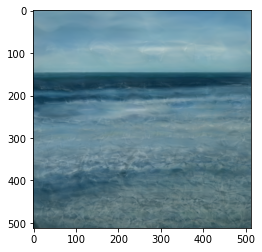

In [19]:
plt.imshow((image_test.squeeze(0).permute(1,2,0)*127.5+128).clamp(0,255).to(torch.uint8).cpu())

In [20]:
test = G.synthesis(E(my_trans(my_image_bottom[7]).unsqueeze(0).to(device)))

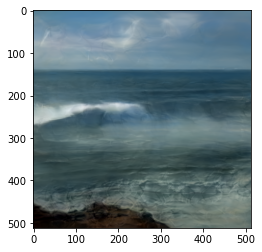

In [21]:
plt.imshow((test.squeeze(0).permute(1,2,0)*127.5+128).clamp(0,255).to(torch.uint8).cpu())

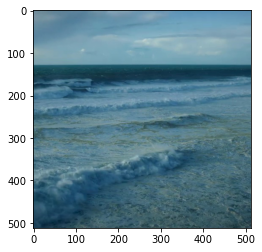

In [22]:
plt.imshow(PIL.Image.open(my_image_top[4]).convert('RGB'))